In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

2022-10-04 15:36:23.401875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Generate Data

In [2]:
class DummyData:
    """
    y = \sum_{i=0}^{n-1} a_{i} x_{i} + noise
    
    """
    
    def __init__(self, num_feats: int):
        self._target_name = "y"
        self._feat_names = [f"x{i}" for i in range(num_feats)]
    
    
    @property
    def target_name(self) -> str:
        return self._target_name
    
    @property
    def feat_names(self) -> list[str]:
        return self._feat_names

    def generate_dummy_data(
        self,
        n_sample: int,
        x_terms: list[tuple[float, float, float]],
        std_noise: float, 
        seed: int = 0
    ) -> pd.DataFrame:
        """
        n_sample (int): number of samples
        x_terms (list[tuple[float, float, float]]): feature X's. Each element in a list has 3 units
                                                    (coefficient, lower bound, upper bound)
                                                    A uniform data range will be generated
        
        std_noise (float): Gaussian noise standard deviation
        seed (int): random seed (default = 0)
        """
        
        assert len(x_terms) == len(self._feat_names)
        
        data = {}
        y = 0.
        for feat_name, (coef, lower, upper) in zip(self._feat_names, x_terms):
            x = np.linspace(lower, upper, n_sample)
            data[feat_name] = x

            y += coef * x

        y += np.random.normal(loc=0, scale=std_noise, size=(n_sample,))

        data[self._target_name] = y


        return pd.DataFrame(data)

In [3]:
dummy_data = DummyData(num_feats=3)

df_data = dummy_data.generate_dummy_data(
    n_sample=1000,
    x_terms=[
        (0.5, -20, 20),
        (-2.45, -10, 10),
        (1.4, -15, 15)
    ],
    std_noise=0.1,
)

df_data

,x0,x1,x2,y
0,-20.00000,-10.00000,-15.00000,-6.633355
1,-19.95996,-9.97998,-14.96997,-6.241427
2,-19.91992,-9.95996,-14.93994,-6.527927
3,-19.87988,-9.93994,-14.90991,-6.365715
4,-19.83984,-9.91992,-14.87988,-6.362373
...,...,...,...,...
995,19.83984,9.91992,14.87988,6.494044
996,19.87988,9.93994,14.90991,6.378355
997,19.91992,9.95996,14.93994,6.522348
998,19.95996,9.97998,14.96997,6.409032


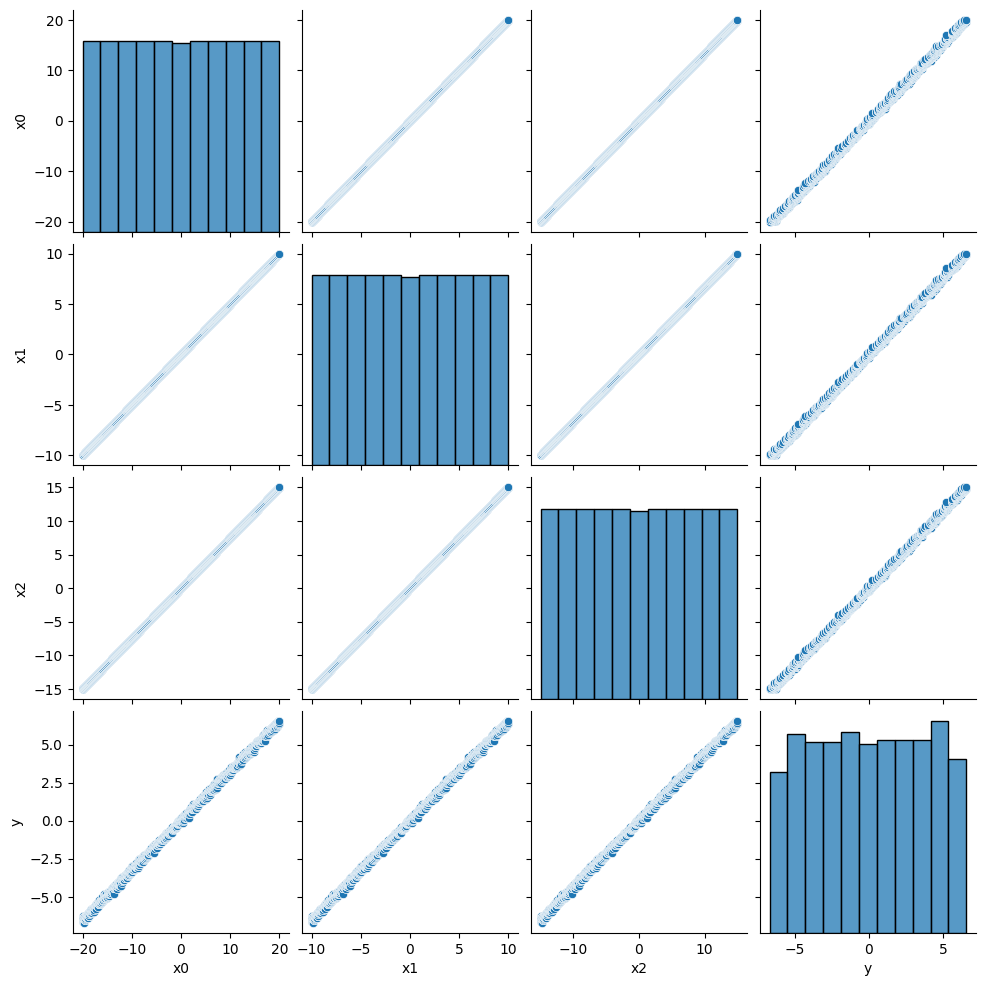

In [4]:
sns.pairplot(df_data)

# Train Test Split

In [5]:
def train_test_split(
    df: pd.DataFrame,
    train_frac: float, 
    random_state: int = 0
) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_train = df.sample(frac=train_frac, random_state=random_state)
    df_test = df.drop(df_train.index, axis=0)
    return df_train, df_test

In [6]:
df_train, df_test = train_test_split(df_data, 0.7)
df_train

,x0,x1,x2,y
993,19.759760,9.879880,14.819820,6.487650
859,14.394394,7.197197,10.795796,4.649248
298,-8.068068,-4.034034,-6.051051,-2.622440
553,2.142142,1.071071,1.606607,0.768380
672,6.906907,3.453453,5.180180,2.227581
...,...,...,...,...
509,0.380380,0.190190,0.285285,0.214501
340,-6.386386,-3.193193,-4.789790,-2.099185
221,-11.151151,-5.575576,-8.363363,-3.692527
928,17.157157,8.578579,12.867868,5.581884


# Train Model

In [7]:
class LinearRegressor:
    def __init__(self, feat_names: list[str], target_name: str):
        self._feat_names = feat_names
        self._target_name = target_name
        self._model: tf.keras.Model | None = None
            
    
    @property
    def model(self) -> tf.keras.Model:
        return self._model
    
    def compile_model(self, df: pd.DataFrame) -> None:
        num_feats = len(self._feat_names)
        
        # normalise input features to zero mean and unit variance
        normalizer = tf.keras.layers.Normalization(input_shape=(num_feats,), name="normalizer")
        normalizer.adapt(df[self._feat_names])

        model = tf.keras.Sequential(
            [
                normalizer,
                tf.keras.layers.Dense(units=1)
            ],
            name="linear_regressor"
        )

        model.compile(
            # learning rate if too small would converage slowly for linear regression
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
            loss=tf.keras.losses.MeanSquaredError()
        )

        self._model = model
        print(self._model.summary())
        
    
    def fit(self, df: pd.DataFrame) -> None:
        self._model.fit(
            x=df[self._feat_names],
            y=df[self._target_name],
            batch_size=32,
            epochs=100,
            validation_split=0.2,
        )
        
    def evaluate(self, df: pd.DataFrame) -> float:
        loss = self._model.evaluate(
            x=df_test[dummy_data.feat_names],
            y=df_test[dummy_data.target_name],
            verbose=0,
        )
        return loss
    
    def predict(self, df: pd.DataFrame) -> np.array:
        return self._model.predict(x=df[self._feat_names])
    
    def to_tf(self, filepath: str) -> None:
        self._model.save(filepath, save_format="t5")

In [8]:
linear_regressor = LinearRegressor(
    feat_names=dummy_data.feat_names,
    target_name=dummy_data.target_name,
)

linear_regressor.compile_model(df_train)
linear_regressor.fit(df_train)

2022-10-04 15:36:30.665241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "linear_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalizer (Normalization)  (None, 3)                 7         
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 11
Trainable params: 4
Non-trainable params: 7
_________________________________________________________________
None
Epoch 1/100


/Users/bpht/.pyenv/versions/jupyter/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


18/18 [==============================] - 1s 10ms/step - loss: 0.6578 - val_loss: 0.0699
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0666 - val_loss: 0.0156
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0245 - val_loss: 0.0194
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0141 - val_loss: 0.0080
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0120 - val_loss: 0.0079
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0119 - val_loss: 0.0085
Epoch 7/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0118 - val_loss: 0.0078
Epoch 8/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0122 - val_loss: 0.0104
Epoch 9/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0123 - val_loss: 0.0092
Epoch 10/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0121 - val_loss: 0.0091
Epoch 11/100
18/18 [

18/18 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.0078
Epoch 84/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0128 - val_loss: 0.0079
Epoch 85/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0121 - val_loss: 0.0081
Epoch 86/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0120 - val_loss: 0.0083
Epoch 87/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0130 - val_loss: 0.0109
Epoch 88/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0146 - val_loss: 0.0086
Epoch 89/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.0084
Epoch 90/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0118 - val_loss: 0.0094
Epoch 91/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.0087
Epoch 92/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0077
Epoch 93/100


In [9]:
# evaluate test set
linear_regressor.evaluate(df_test)

0.012976529076695442

# Residual Plot

In [10]:
def visualise(
    df: pd.DataFrame,
    regressor: LinearRegressor,
    target_name: str,
    dataset_name: str,
):
    fig, axes = plt.subplots(nrows=2)
    fig.set_figheight(8)
    fig.set_figwidth(8)

    # first plot yhat vs y
    ax = axes[0]
    actual = df[target_name].values.reshape(-1, 1)
    pred = regressor.predict(df)
    ax.scatter(actual, pred, s=8)
    x_lim = ax.get_xlim()
    xs = np.linspace(*x_lim)
    ax.plot(xs, xs, color="r")
    ax.grid(True, which="both")
    ax.set_xlabel(r"Actual $y$")
    ax.set_ylabel(r"Predicted $\hat{y}$")
    ax.set_title(dataset_name)

    # second plot residual
    residual = actual - pred
    ax = axes[1]

    n = 2 * int(np.sqrt(len(residual)))
    ax.hist(residual, bins=n)
    ax.set_xlabel(r"Residual: $y - \hat{y}$")
    ax.set_ylabel("Count")
    ax.set_title(dataset_name)
    ax.grid(True, which="both")

    plt.tight_layout(h_pad=2)

22/22 [==============================] - 0s 868us/step


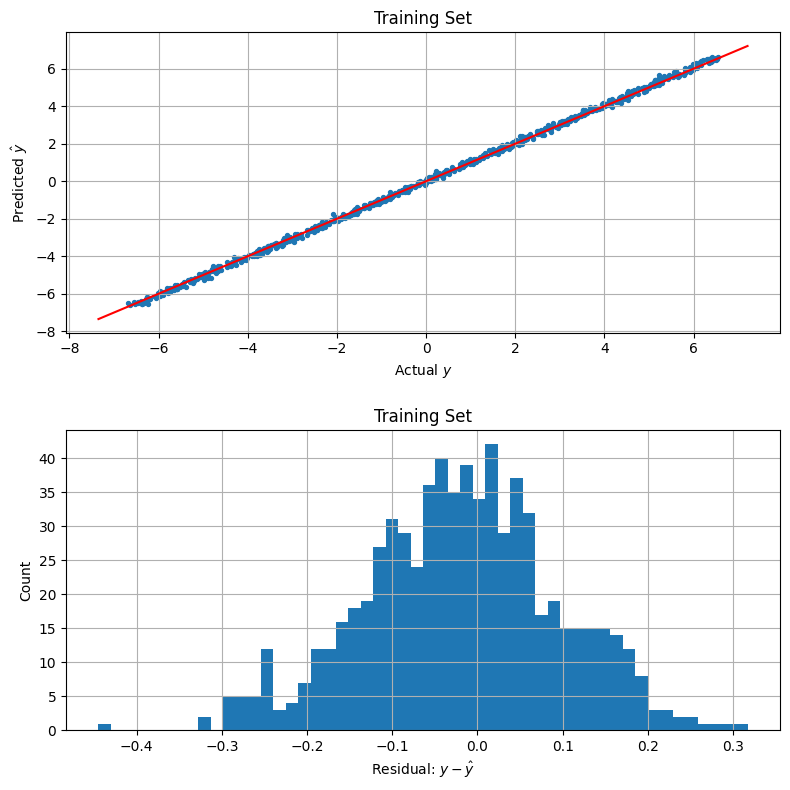

In [11]:
visualise(df_train, linear_regressor,  dummy_data.target_name, dataset_name="Training Set")

10/10 [==============================] - 0s 1ms/step


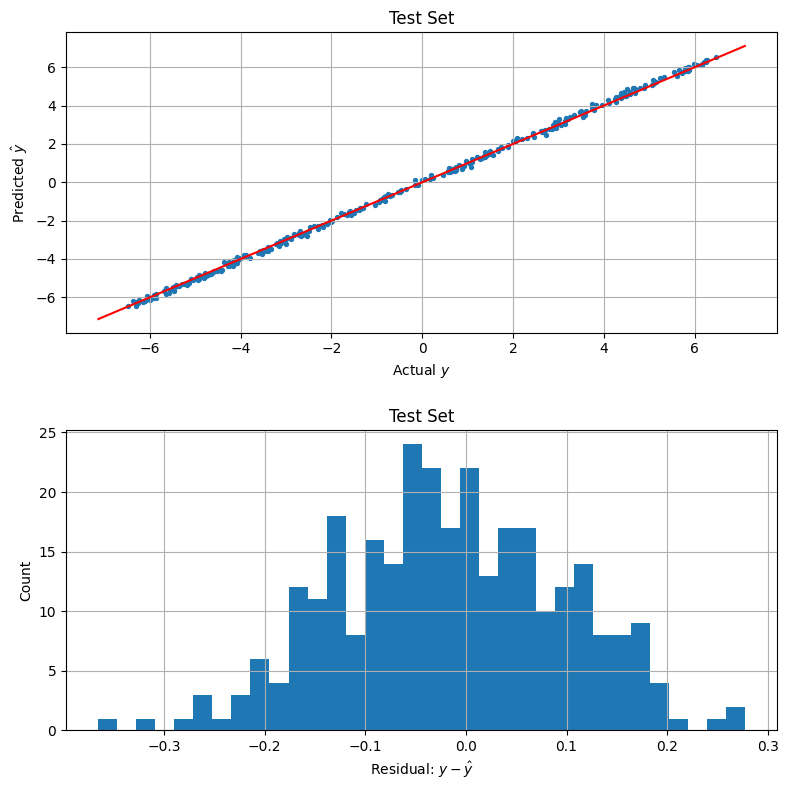

In [12]:
visualise(df_test, linear_regressor,  dummy_data.target_name, dataset_name="Test Set")

In [13]:
linear_regressor.to_tf("linear_regressor")

INFO:tensorflow:Assets written to: linear_regressor.tf/assets
